In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

1 #define _CUDA_NDARRAY_C
2 
3 #include <Python.h>
4 #include <structmember.h>
5 #include "theano_mod_helper.h"
6 
7 #include <numpy/arrayobject.h>
8 #include <iostream>
9 
10 #include "cuda_ndarray.cuh"
11 
12 #ifndef CNMEM_DLLEXPORT
13 #define CNMEM_DLLEXPORT
14 #endif
15 
16 #include "cnmem.h"
17 #include "cnmem.cpp"
18 
19 //If true, when there is a gpu malloc or free error, we print the size of allocated memory on the device.
20 #define COMPUTE_GPU_MEM_USED 0
21 
22 //If true, we fill with NAN allocated device memory.
23 #define ALLOC_MEMSET 0
24 
25 //If true, we print out when we free a device pointer, uninitialize a
26 //CudaNdarray, or allocate a device pointer
27 #define PRINT_FREE_MALLOC 0
28 
29 //If true, we do error checking at the start of functions, to make sure there
30 //is not a pre-existing error when the function is called.
31 //You probably need to set the environment variable
32 //CUDA_LAUNCH_BLOCKING=1, and/or modify the CNDA_THREAD_SYNC
33 //preprocessor macro 


['nvcc', '-shared', '-O3', '-m64', '-Xcompiler', '-DCUDA_NDARRAY_CUH=mc72d035fdf91890f3b36710688069b2e,-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION,-fPIC,-fvisibility=hidden', '-Xlinker', '-rpath,/home/ericmjl/.theano/compiledir_Linux-4.8--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.0-64/cuda_ndarray', '-I/home/ericmjl/anaconda/lib/python3.6/site-packages/theano/sandbox/cuda', '-I/home/ericmjl/anaconda/lib/python3.6/site-packages/numpy/core/include', '-I/home/ericmjl/anaconda/include/python3.6m', '-I/home/ericmjl/anaconda/lib/python3.6/site-packages/theano/gof', '-o', '/home/ericmjl/.theano/compiledir_Linux-4.8--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.0-64/cuda_ndarray/cuda_ndarray.so', 'mod.cu', '-L/home/ericmjl/anaconda/lib', '-lcublas', '-lpython3.6m', '-lcudart']


In [15]:
# Generate some fake data.
x_concs = np.arange(0, 100, 10).reshape(-1, 1)
log_xconcs = np.log(x_concs)
ic50_true = np.array([42, 13, 88])
ic50_true = ic50_true.reshape(-1, ic50_true.shape[0])
beta_true = 1
slope_true = 1
intercept_true = 150
# y_true = slope_true * x_concs + intercept_true

y_true = beta_true / (1 + np.exp(x_concs - ic50_true))

y_noisy = y_true + np.random.normal(0, 0.05, size=y_true.shape)  # homoskedastic error
y_noisy

array([[  1.02382396e+00,   9.92127722e-01,   9.92332769e-01],
       [  9.61756008e-01,   9.34075595e-01,   9.83770063e-01],
       [  8.81221170e-01,   5.17782820e-02,   1.04801942e+00],
       [  9.43563617e-01,  -3.90627999e-02,   1.09646541e+00],
       [  8.93955928e-01,   6.33172680e-02,   9.10614828e-01],
       [ -7.46524604e-02,   5.66623102e-04,   9.76183389e-01],
       [ -1.00701749e-01,   1.35127451e-02,   1.02219831e+00],
       [ -3.46585496e-02,  -3.61710977e-02,   9.84535889e-01],
       [ -2.80715220e-02,  -3.71833838e-03,   9.83069748e-01],
       [ -1.46720128e-02,  -1.08369706e-02,   1.90246760e-01]])

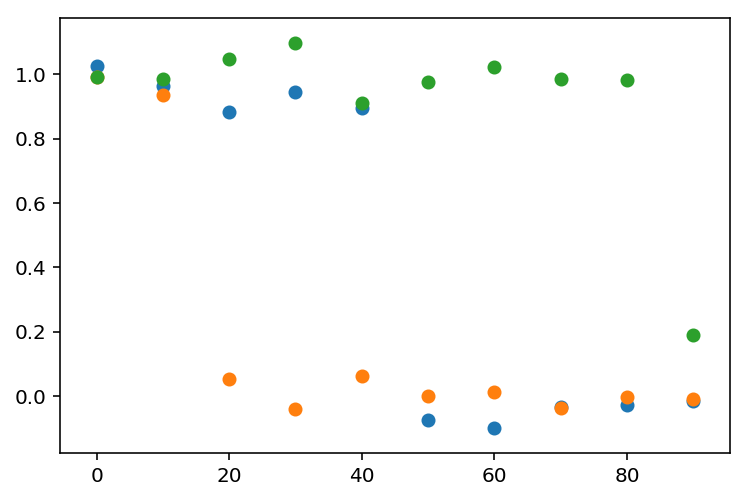

In [17]:
plt.scatter(x_concs, y_noisy[:, 0])
plt.scatter(x_concs, y_noisy[:, 1])
plt.scatter(x_concs, y_noisy[:, 2])

In [23]:
concentrations = np.concatenate([x_concs] * ic50_true.shape[1])
concentrations

array([[ 0],
       [10],
       [20],
       [30],
       [40],
       [50],
       [60],
       [70],
       [80],
       [90],
       [ 0],
       [10],
       [20],
       [30],
       [40],
       [50],
       [60],
       [70],
       [80],
       [90],
       [ 0],
       [10],
       [20],
       [30],
       [40],
       [50],
       [60],
       [70],
       [80],
       [90]])

In [24]:
concentrations.shape

(30, 1)

In [25]:
y_noisy.flatten(order='F')

array([  1.02382396e+00,   9.61756008e-01,   8.81221170e-01,
         9.43563617e-01,   8.93955928e-01,  -7.46524604e-02,
        -1.00701749e-01,  -3.46585496e-02,  -2.80715220e-02,
        -1.46720128e-02,   9.92127722e-01,   9.34075595e-01,
         5.17782820e-02,  -3.90627999e-02,   6.33172680e-02,
         5.66623102e-04,   1.35127451e-02,  -3.61710977e-02,
        -3.71833838e-03,  -1.08369706e-02,   9.92332769e-01,
         9.83770063e-01,   1.04801942e+00,   1.09646541e+00,
         9.10614828e-01,   9.76183389e-01,   1.02219831e+00,
         9.84535889e-01,   9.83069748e-01,   1.90246760e-01])

In [31]:
x_concs.shape[0]

10

In [33]:
data = pd.DataFrame()
data['concentrations'] = concentrations.reshape(concentrations.shape[0],)
data['measurements'] = y_noisy.flatten(order='F')

drugs = []
for i in range(ic50_true.shape[1]):
    drugs.extend([i] * x_concs.shape[0])
data['drug'] = drugs

from sklearn.preprocessing import LabelEncoder, MinMaxScaler

le = LabelEncoder()
data['idxs'] = le.fit_transform(data['drug'])

# Normalize data['measurements'] to 0-1
# mms = MinMaxScaler()
# data['measurements'] = mms.fit_transform(data['measurements'].values.reshape(-1, 1))

In [34]:
data

,concentrations,measurements,drug,idxs
0,0,1.023824,0,0
1,10,0.961756,0,0
2,20,0.881221,0,0
3,30,0.943564,0,0
4,40,0.893956,0,0
5,50,-0.074652,0,0
6,60,-0.100702,0,0
7,70,-0.034659,0,0
8,80,-0.028072,0,0
9,90,-0.014672,0,0


In [35]:
with pm.Model() as model:
    beta = pm.Normal('beta', mu=0, sd=100**2, shape=len(set(data['idxs'])))    
    noise = pm.HalfCauchy('noise', beta=100**2, shape=len(set(data['idxs'])))
    ic50 = pm.Normal('IC50', sd=100**2, shape=len(set(data['idxs'])))
    measurements = beta[data['idxs']] / (1 + np.exp(data['concentrations'].values - ic50[data['idxs']]))

    
    y_like = pm.Normal('y_like', mu=measurements, sd=noise[data['idxs']], observed=data['measurements'])

In [36]:
with model:
    trace = pm.sample(draws=10000, step=pm.Metropolis(), start=pm.find_MAP())

Optimization terminated successfully.
         Current function value: 47.023561
         Iterations: 109
         Function evaluations: 191
         Gradient evaluations: 191


100%|██████████| 10000/10000 [00:02<00:00, 4002.43it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7eff249b03c8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7eff246938d0>]], dtype=object)

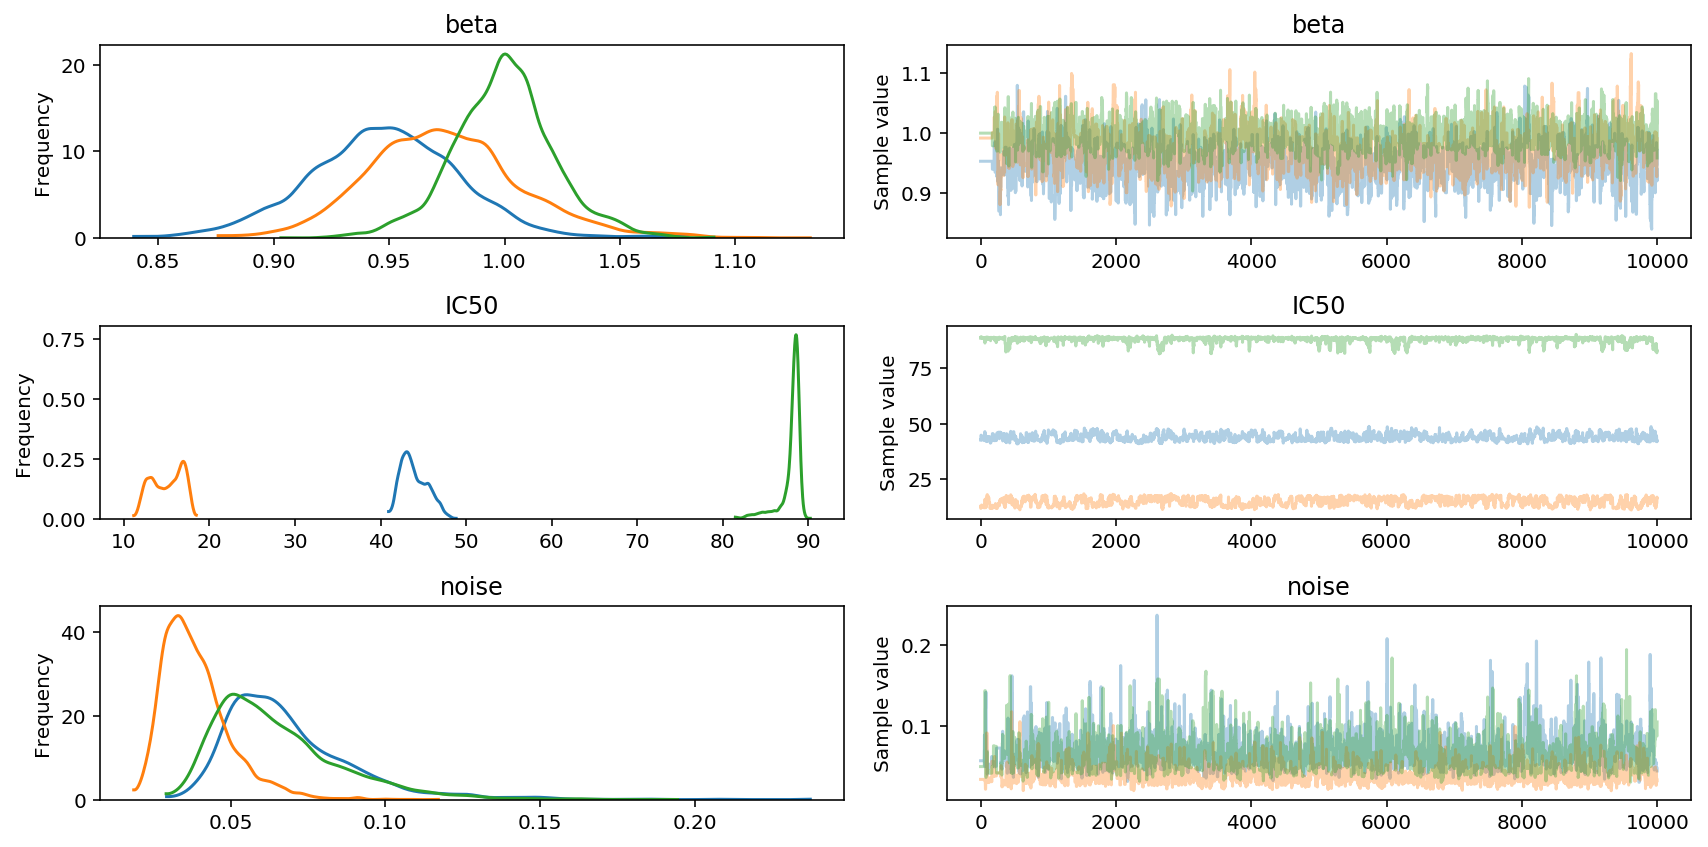

In [37]:
pm.traceplot(trace)

In [38]:
pm.summary(trace)


beta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.948            0.033            0.001            [0.881, 1.010]
  0.974            0.033            0.002            [0.910, 1.042]
  0.999            0.022            0.001            [0.955, 1.047]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.882          0.926          0.948          0.969          1.012
  0.913          0.951          0.972          0.993          1.046
  0.953          0.986          1.000          1.012          1.046


IC50:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  43.945           1.551            0.080            [41.502, 47.027]
  15.050           1.811            0.111            [12.117,